# 探索型データ分析
Nishokaで取得したサンプルデータを利用しPythonライブラリによるデータ操作の基本を学ぶ。  
データ内容を整理、視覚化しモデル学習を行うための準備をする。

参考:Nishika・中古マンション価格予測 https://competition.nishika.com/competitions/mansion_pra/summary

In [39]:
# データ分析に必要なライブラリを読み込む
import glob
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# font設定
%pip install japanize-matplotlib
import japanize_matplotlib 
sns.set(font='IPAexGothic')
matplotlib.rcParams["font.family"] = "IPAexGothic"

Note: you may need to restart the kernel to use updated packages.


In [40]:
# 全てのサンプルCSVを読み込む
# CSVデータを配列で取得
files = glob.glob("/workspace/ApartmentPricePrediction/train/*.csv")
# 取得したデータをread_csvで操作可能な値としてdata_listに配列として保存する
data_list = []
for file in files:
  data_list.append(pd.read_csv(file, index_col=0))

# 配列内のデータを全て１つに結合する
df = pd.concat(data_list)

/tmp/ipykernel_616/3961263273.py:7: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  data_list.append(pd.read_csv(file, index_col=0))
/tmp/ipykernel_616/3961263273.py:7: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  data_list.append(pd.read_csv(file, index_col=0))


In [41]:
# 行数と列数の表示
df.shape

(637351, 27)

In [42]:
# 欠損データ数とデータタイプの表示
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 637351 entries, 1060685 to 47003572
Data columns (total 27 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   種類            637351 non-null  object 
 1   地域            0 non-null       float64
 2   市区町村コード       637351 non-null  int64  
 3   都道府県名         637351 non-null  object 
 4   市区町村名         637351 non-null  object 
 5   地区名           637060 non-null  object 
 6   最寄駅：名称        634732 non-null  object 
 7   最寄駅：距離（分）     614306 non-null  object 
 8   間取り           615609 non-null  object 
 9   面積（㎡）         637351 non-null  object 
 10  土地の形状         0 non-null       float64
 11  間口            0 non-null       float64
 12  延床面積（㎡）       0 non-null       float64
 13  建築年           619117 non-null  object 
 14  建物の構造         623423 non-null  object 
 15  用途            591214 non-null  object 
 16  今後の利用目的       275091 non-null  object 
 17  前面道路：方位       0 non-null       float64
 

In [43]:
# データが全てnullのカラムを削除したい

# 空のカラムをリストに入れたい
nonnull_list = []

# データフレームの全ての各カラムに対しループ処理
for col in df.columns:
  nonnull = df[col].count()
  if nonnull == 0:
    # データが0のカラムをリストに追加
    nonnull_list.append(col)

# 上記の空のカラムを除外する
df = df.drop(nonnull_list, axis=1)

axisオプションはその処理を行に沿って実行するか、列に沿って実行するか指定する  
https://qiita.com/Phoeboooo/items/b464b7df3c64a33caf94

In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 637351 entries, 1060685 to 47003572
Data columns (total 20 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   種類            637351 non-null  object 
 1   市区町村コード       637351 non-null  int64  
 2   都道府県名         637351 non-null  object 
 3   市区町村名         637351 non-null  object 
 4   地区名           637060 non-null  object 
 5   最寄駅：名称        634732 non-null  object 
 6   最寄駅：距離（分）     614306 non-null  object 
 7   間取り           615609 non-null  object 
 8   面積（㎡）         637351 non-null  object 
 9   建築年           619117 non-null  object 
 10  建物の構造         623423 non-null  object 
 11  用途            591214 non-null  object 
 12  今後の利用目的       275091 non-null  object 
 13  都市計画          618786 non-null  object 
 14  建ぺい率（％）       614848 non-null  float64
 15  容積率（％）        614848 non-null  float64
 16  取引時点          637351 non-null  object 
 17  改装            580431 non-null  object 
 

## 多重共線性  
重回帰モデルにおいて、説明変数の中に相関係数が高い組み合わせがあるモデルの予測や信頼性が下がる  
上記データのうち、相関の高い要素を除外したい

In [45]:
# 市区町村と市区町村コードは完全に一致したものではないか？

# value_countsを使用して、データの種類と数を比較する
df["市区町村コード"].value_counts()

13111    12269
13108    11591
13112    10747
13103    10580
13104    10055
         ...  
40604        1
40213        1
40212        1
40341        1
34309        1
Name: 市区町村コード, Length: 618, dtype: int64

In [46]:
df["市区町村名"].value_counts()

大田区       12269
江東区       11591
世田谷区      10747
港区        10580
新宿区       10055
          ...  
田川郡糸田町        1
行橋市           1
大川市           1
粕屋郡宇美町        1
安芸郡坂町         1
Name: 市区町村名, Length: 618, dtype: int64

市区町村コードと市区町村名において、データの種類と数が完全に一致している  
上記の結果は、市区町村名と対応する市区町村コードが618個あり、そのそれぞれの出現回数も一致していることを表す

In [47]:
# どちらか一方のカラム(今回は市区町村名)を削除する
df = df.drop("市区町村名", axis=1)

In [48]:
# 統計量の確認

# デフォルトでは数値型が分析対象となり、データ数、平均、四分位数など表示される
df.describe()

,市区町村コード,建ぺい率（％）,容積率（％）,取引価格（総額）_log
count,637351.000000,614848.000000,614848.000000,637351.000000
mean,18513.985300,67.601944,301.601876,7.217424
std,9596.722442,10.402295,148.105400,0.353935
min,1101.000000,30.000000,50.000000,2.653213
25%,13106.000000,60.000000,200.000000,7.000000
50%,14104.000000,60.000000,200.000000,7.255273
75%,27114.000000,80.000000,400.000000,7.447158
max,47213.000000,80.000000,1300.000000,9.934498


In [49]:
# astypeを使い分析対象を文字列型に指定すると、データ数、データ種類が表示される
df.astype(str).describe()

,種類,市区町村コード,都道府県名,地区名,最寄駅：名称,最寄駅：距離（分）,間取り,面積（㎡）,建築年,建物の構造,用途,今後の利用目的,都市計画,建ぺい率（％）,容積率（％）,取引時点,改装,取引の事情等,取引価格（総額）_log
count,637351,637351,637351,637351,637351,637351,637351,637351,637351,637351,637351,637351,637351,637351,637351,637351,637351,637351,637351
unique,1,618,47,12047,3832,35,64,114,77,13,23,5,17,7,18,58,3,10,380
top,中古マンション等,13111,東京都,本町,nan,6,３ＬＤＫ,70,平成3年,ＲＣ,住宅,nan,商業地域,60.0,200.0,2014年第１四半期,未改装,nan,7.176091259055681
freq,637351,12269,190524,5267,2619,50928,272449,83443,21982,431050,583722,362260,172628,349347,293388,13561,419268,619076,20996


## データの種類が1つしかないカラムを除外する  

In [50]:
df["種類"].value_counts()

中古マンション等    637351
Name: 種類, dtype: int64

In [51]:
# 種類カラムを削除
df = df.drop("種類", axis=1)

## データ型の変換

In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 637351 entries, 1060685 to 47003572
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   市区町村コード       637351 non-null  int64  
 1   都道府県名         637351 non-null  object 
 2   地区名           637060 non-null  object 
 3   最寄駅：名称        634732 non-null  object 
 4   最寄駅：距離（分）     614306 non-null  object 
 5   間取り           615609 non-null  object 
 6   面積（㎡）         637351 non-null  object 
 7   建築年           619117 non-null  object 
 8   建物の構造         623423 non-null  object 
 9   用途            591214 non-null  object 
 10  今後の利用目的       275091 non-null  object 
 11  都市計画          618786 non-null  object 
 12  建ぺい率（％）       614848 non-null  float64
 13  容積率（％）        614848 non-null  float64
 14  取引時点          637351 non-null  object 
 15  改装            580431 non-null  object 
 16  取引の事情等        18275 non-null   object 
 17  取引価格（総額）_log  637351 non-null  float64
d

## 最寄り駅：距離(分)のデータの内容確認

In [53]:
# 集計データの表示オプションを20に設定
pd.set_option("display.max_rows", 20) 
df["最寄駅：距離（分）"].value_counts()

6          50928
4          48883
5          45337
8          44277
3          42880
           ...  
17          2515
22          1082
2H?          826
1H30?2H      692
27           412
Name: 最寄駅：距離（分）, Length: 34, dtype: int64

In [54]:
# 数値以外の文字は変換する
# 例)、30分?60分(30分～60分)は45、1H?1H30(1h～1h30)は75など

# 試しに変換
df_temp = df["最寄駅：距離（分）"].replace("1H?1H30",75)
df_temp.value_counts()

6          50928
4          48883
5          45337
8          44277
3          42880
           ...  
17          2515
22          1082
2H?          826
1H30?2H      692
27           412
Name: 最寄駅：距離（分）, Length: 34, dtype: int64

In [55]:
# 変換処理を一括で実行

# 変換用のオブジェクトを作成
distance = {
  "30分?60分":45,
  "1H?1H30":75,
  "2H?":120,
  "1H30?2H":105
}

In [56]:
# もともとのカラム"最寄駅：距離（分）"に変換後のカラムを代入

# replaceにオブジェクトを渡すといい感じに変換してくれる
df["最寄駅：距離（分）"] = df["最寄駅：距離（分）"].replace(distance).astype(float)
df["最寄駅：距離（分）"].value_counts()

6.0      50928
4.0      48883
5.0      45337
8.0      44277
3.0      42880
         ...  
17.0      2515
22.0      1082
120.0      826
105.0      692
27.0       412
Name: 最寄駅：距離（分）, Length: 34, dtype: int64

### 面積のデータ内容確認

In [57]:
df["面積（㎡）"].value_counts()

70     70301
65     65176
60     51968
75     47362
20     40770
       ...  
990        1
780        1
530        1
800        1
570        1
Name: 面積（㎡）, Length: 195, dtype: int64

In [58]:
# 2000以上を2000に変換
df["面積（㎡）"] = df["面積（㎡）"].replace("2000㎡以上",2000).astype(float) 
df["面積（㎡）"].value_counts()

70.0     83443
65.0     78289
60.0     63257
75.0     56644
20.0     52028
         ...  
960.0        1
540.0        1
550.0        1
720.0        1
570.0        1
Name: 面積（㎡）, Length: 114, dtype: int64

## 和暦の変換

### 建築年

In [59]:
# keysを指定するとKeyのみを配列で取得できる
df["建築年"].value_counts().keys()

Index(['平成3年', '平成20年', '平成18年', '平成19年', '平成10年', '平成15年', '平成12年', '平成17年',
       '平成7年', '平成2年', '平成8年', '平成14年', '平成9年', '平成13年', '平成11年', '平成16年',
       '昭和64年', '平成4年', '昭和63年', '平成21年', '平成6年', '昭和62年', '昭和59年', '昭和60年',
       '昭和61年', '昭和49年', '平成5年', '平成22年', '昭和54年', '昭和57年', '昭和55年', '昭和56年',
       '平成24年', '平成23年', '昭和48年', '昭和58年', '昭和53年', '平成25年', '昭和50年', '昭和52年',
       '平成26年', '昭和51年', '昭和47年', '平成27年', '昭和46年', '昭和45年', '平成28年', '昭和44年',
       '昭和43年', '平成29年', '平成30年', '昭和42年', '平成31年', '昭和41年', '戦前', '昭和40年',
       '昭和39年', '昭和38年', '令和2年', '昭和37年', '昭和34年', '昭和22年', '昭和36年', '昭和21年',
       '昭和33年', '昭和28年', '昭和25年', '昭和35年', '昭和24年', '昭和29年', '昭和27年', '昭和31年',
       '昭和23年', '昭和26年', '昭和32年', '昭和30年'],
      dtype='object')

In [60]:
# splitを使用して指定した値で文字列を分割しながら数値のみ取り出す

# 例えば、最初のKeyから数値だけを取り出すとこのようになる
df["建築年"].value_counts().keys()[0].split("平成")[1].split("年")[0]

'3'

In [61]:
# 一括で処理する

y_list = {}

for yearStr in df["建築年"].value_counts().keys():
  if "平成" in yearStr:
    num = float(yearStr.split("平成")[1].split("年")[0])
    year = 33 - num
  if "令和" in yearStr:
    num = float(yearStr.split("令和")[1].split("年")[0])
    year = 3 - num
  if "昭和" in yearStr:
    num = float(yearStr.split("昭和")[1].split("年")[0])
    year = 96 - num
    
  y_list[yearStr] = year
df["建築年"] = df["建築年"].replace(y_list)

df["建築年"].value_counts()

30.0    21982
13.0    21947
15.0    21719
14.0    21398
23.0    20749
        ...  
65.0        5
73.0        5
70.0        4
64.0        3
66.0        2
Name: 建築年, Length: 75, dtype: int64

## 取引時点のデータ内容の変換  

第○○半期を少数年に変換する(0.25年など)

In [62]:
df["取引時点"].value_counts()

2014年第１四半期    13561
2017年第１四半期    13248
2015年第１四半期    13237
2013年第１四半期    13233
2013年第２四半期    13221
              ...  
2006年第３四半期     5395
2006年第２四半期     5221
2006年第１四半期     4322
2005年第４四半期     3650
2005年第３四半期     3535
Name: 取引時点, Length: 58, dtype: int64

In [63]:
# 変換の組み合わせのオブジェクトを作成
year = {
  "年第１四半期":".25",
  "年第２四半期":".50",
  "年第３四半期":".75",
  "年第４四半期":".99"
}
yearList = {}
for yearStr in df["取引時点"].value_counts().keys():
# items():ループ対象のオブジェクトからKeyとValueを個別に取り出して処理できる
  for k, j in year.items():
    if k in yearStr:
      yearReg = yearStr.replace(k, j)
  
  yearList[yearStr] = yearReg
      
df["取引時点"] = df["取引時点"].replace(yearList).astype(float)

In [64]:
df["取引時点"].value_counts()

2014.25    13561
2017.25    13248
2015.25    13237
2013.25    13233
2013.50    13221
           ...  
2006.75     5395
2006.50     5221
2006.25     4322
2005.99     3650
2005.75     3535
Name: 取引時点, Length: 58, dtype: int64

## 数値化したデータを視覚化する

取引価格に対して各要素がどのように関係しているか知りたい

- 最寄駅：距離（分）
- 面積（㎡）
- 建築年

In [65]:
df.describe()

,市区町村コード,最寄駅：距離（分）,面積（㎡）,建築年,建ぺい率（％）,容積率（％）,取引時点,取引価格（総額）_log
count,637351.000000,614306.000000,637351.000000,619117.000000,614848.000000,614848.000000,637351.000000,637351.000000
mean,18513.985300,11.731487,58.663570,25.959221,67.601944,301.601876,2013.633153,7.217424
std,9596.722442,12.197090,26.712019,11.431670,10.402295,148.105400,3.884546,0.353935
min,1101.000000,0.000000,10.000000,1.000000,30.000000,50.000000,2005.750000,2.653213
25%,13106.000000,5.000000,45.000000,17.000000,60.000000,200.000000,2010.500000,7.000000
50%,14104.000000,8.000000,65.000000,25.000000,60.000000,200.000000,2013.750000,7.255273
75%,27114.000000,14.000000,75.000000,34.000000,80.000000,400.000000,2016.990000,7.447158
max,47213.000000,120.000000,2000.000000,75.000000,80.000000,1300.000000,2019.990000,9.934498


### ヒストグラムの作成

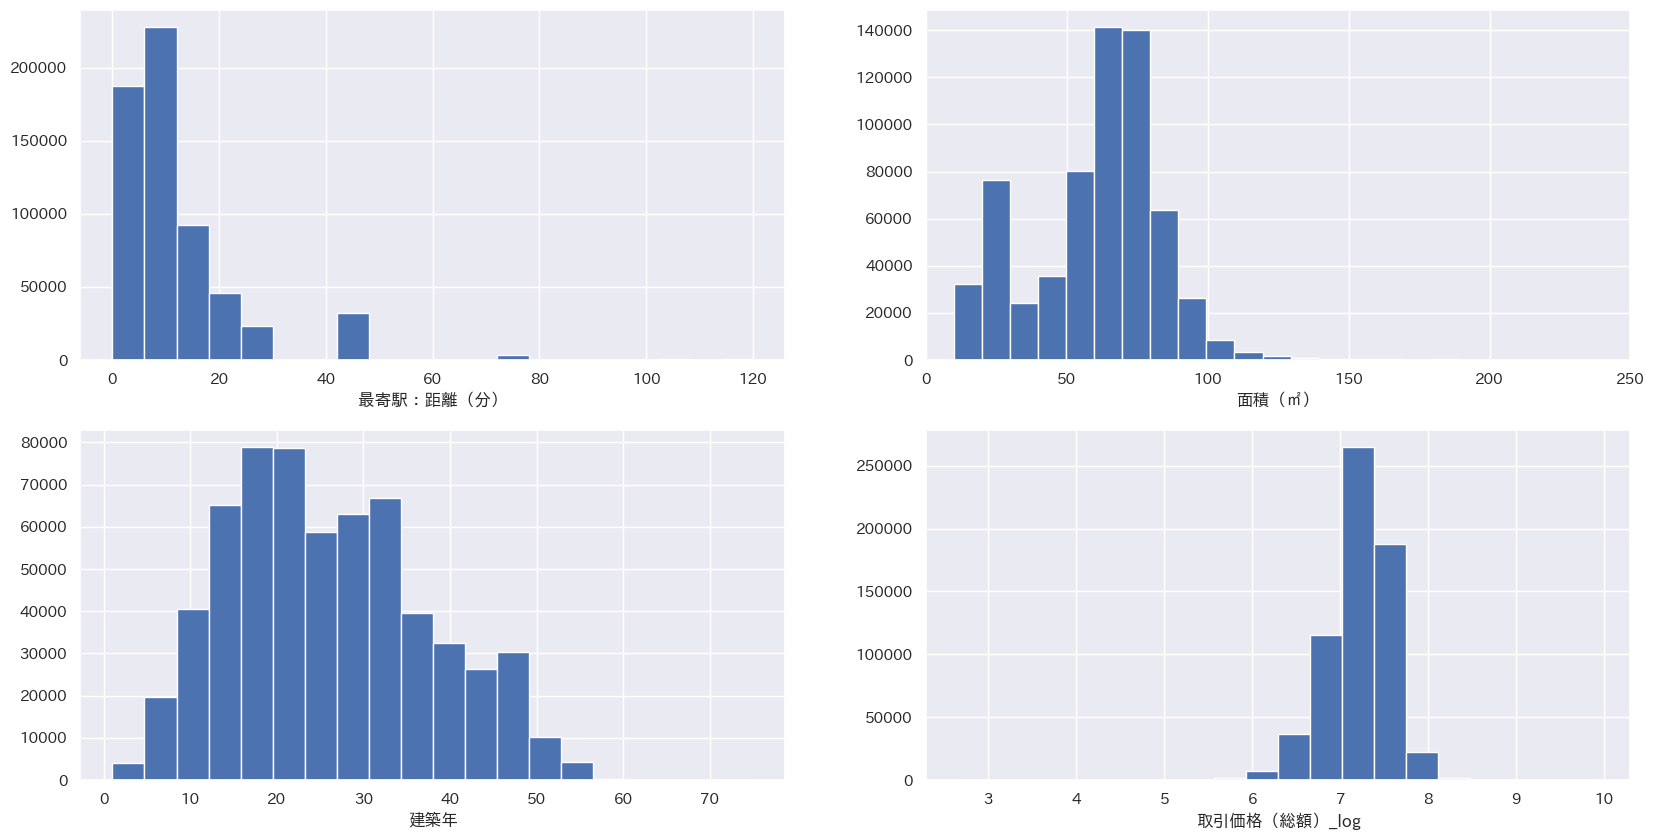

In [78]:
# matplotlibでヒストグラムを表示

fig, axes = plt.subplots(2, 2, figsize=(20, 10))
# binsで区画数を指定,set_xlimでｘ最大/最小値を設定
axes[0][0].hist(df["最寄駅：距離（分）"], bins=20)
axes[0][0].set_xlabel('最寄駅：距離（分）')

axes[0][1].hist(df["面積（㎡）"], bins=200)
axes[0][1].set_xlabel('面積（㎡）')
axes[0][1].set_xlim(0, 250)

axes[1][0].hist(df["建築年"], bins=20)
axes[1][0].set_xlabel('建築年')

axes[1][1].hist(df["取引価格（総額）_log"], bins=20)
axes[1][1].set_xlabel('取引価格（総額）_log')
plt.show()

### 散布図の作成

取引価格に対してそれぞれ最寄り駅距離、面積、築年数を指定して散布図を作成する

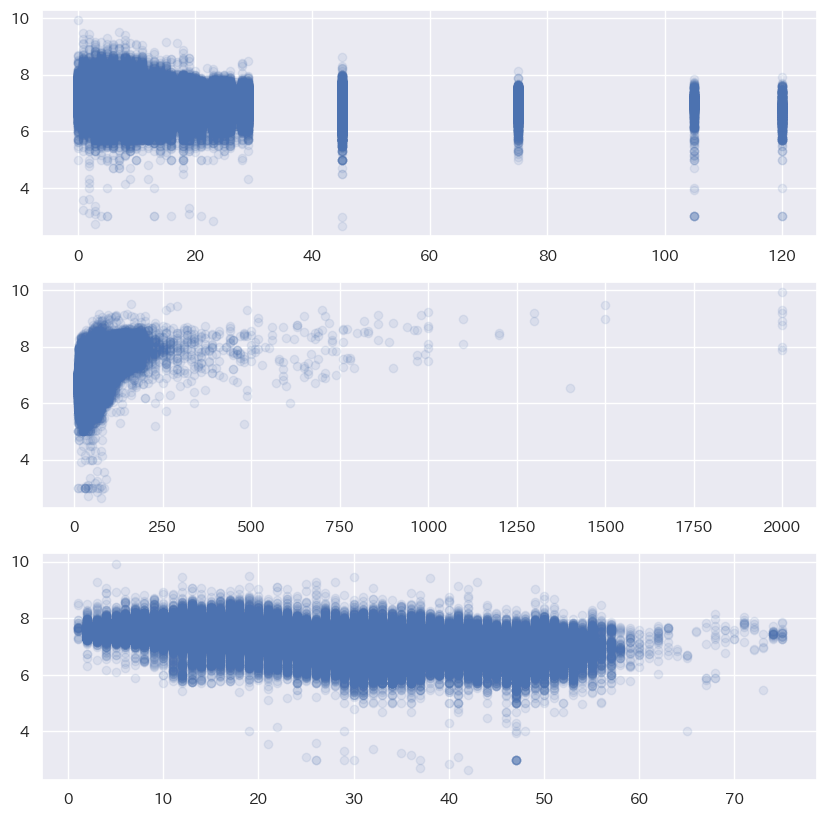

In [67]:
fig, axes = plt.subplots(3, 1, figsize=(10, 10))
axes[0].scatter(df["最寄駅：距離（分）"], df["取引価格（総額）_log"], alpha=0.1)
axes[0].xlabel("x")

axes[1].scatter(df["面積（㎡）"], df["取引価格（総額）_log"], alpha=0.1)
axes[2].scatter(df["建築年"], df["取引価格（総額）_log"], alpha=0.1)
plt.show()


### 視覚化したデータの所感
視覚化したデータについて感じた事  

最寄駅：距離（分）と取引価格について  
- 通常、最寄り駅からの時間が少ないほど、取引価格が高くなる
- しかし上図では明らかな相関は確認できない(若干の負の相関)
- 距離が連続値ではないのは範囲設定されたものを中間値で丸めたため、中間値として設定した各値にデータ数の偏りあり

面積と取引価格について
- 正の相関がありそう
- 特に面積250以上の物件の価格は明らかに高い

築年数と取引価格について
- 負の相関がありそう

### 各データの相関係数を比較する

In [68]:
df[["取引価格（総額）_log", "最寄駅：距離（分）","面積（㎡）","建築年"]].corr()

,取引価格（総額）_log,最寄駅：距離（分）,面積（㎡）,建築年
取引価格（総額）_log,1.000000,-0.215520,0.382755,-0.541508
最寄駅：距離（分）,-0.215520,1.000000,0.151880,0.118339
面積（㎡）,0.382755,0.151880,1.000000,-0.067965
建築年,-0.541508,0.118339,-0.067965,1.000000


取引価格に対して
- 建築年は弱いが負の相関がある
- 面積はもっと弱いが正の相関がある
- 最寄り駅距離との相関はほとんどない

また
- 変数同士に強い相関関係は見られない

### ヒートマップの作成

相関係数のテーブルを色別で視覚化

['IPAexGothic']


<Axes: >

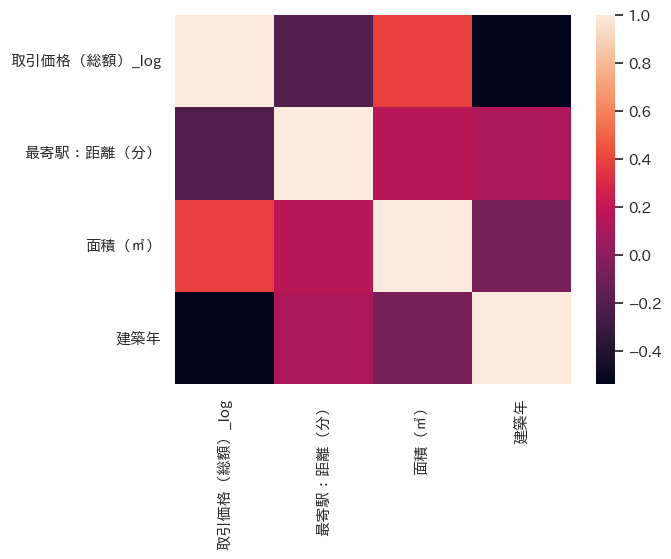

In [69]:
print(plt.rcParams['font.family'])
sns.heatmap(df[["取引価格（総額）_log", "最寄駅：距離（分）","面積（㎡）","建築年"]].corr())


### 取引時点データの視覚化

<Axes: xlabel='取引時点', ylabel='count'>

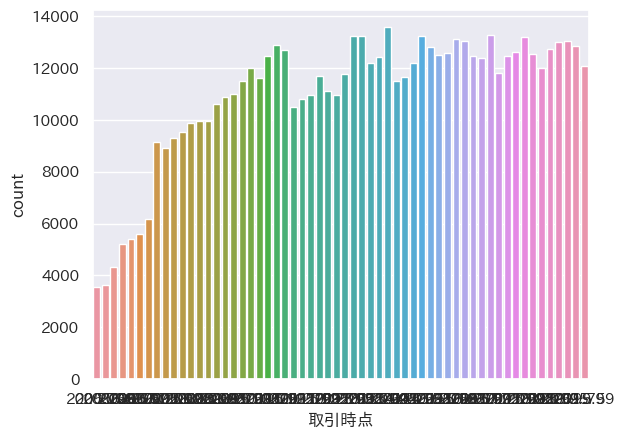

In [70]:
# value_counts()の内容をグラフ化する
# 取引時点の年数を横軸に全て展開して、それぞれが含むデータ数を縦軸に取る
sns.countplot(x="取引時点", data=df)

In [71]:
# 上図の横軸の年数の小数点以下を丸めて集計したい

# 取引時点のInteger型データをlamdaで定義した数式：文字列型にして先頭4文字を取り出す式　Applyを使用してを全件適応させる
# 上記で得たデータで新しいカラム:取引年を作成
df["取引年"] = df["取引時点"].apply(lambda x:str(x)[:4])

<Axes: xlabel='取引時点', ylabel='count'>

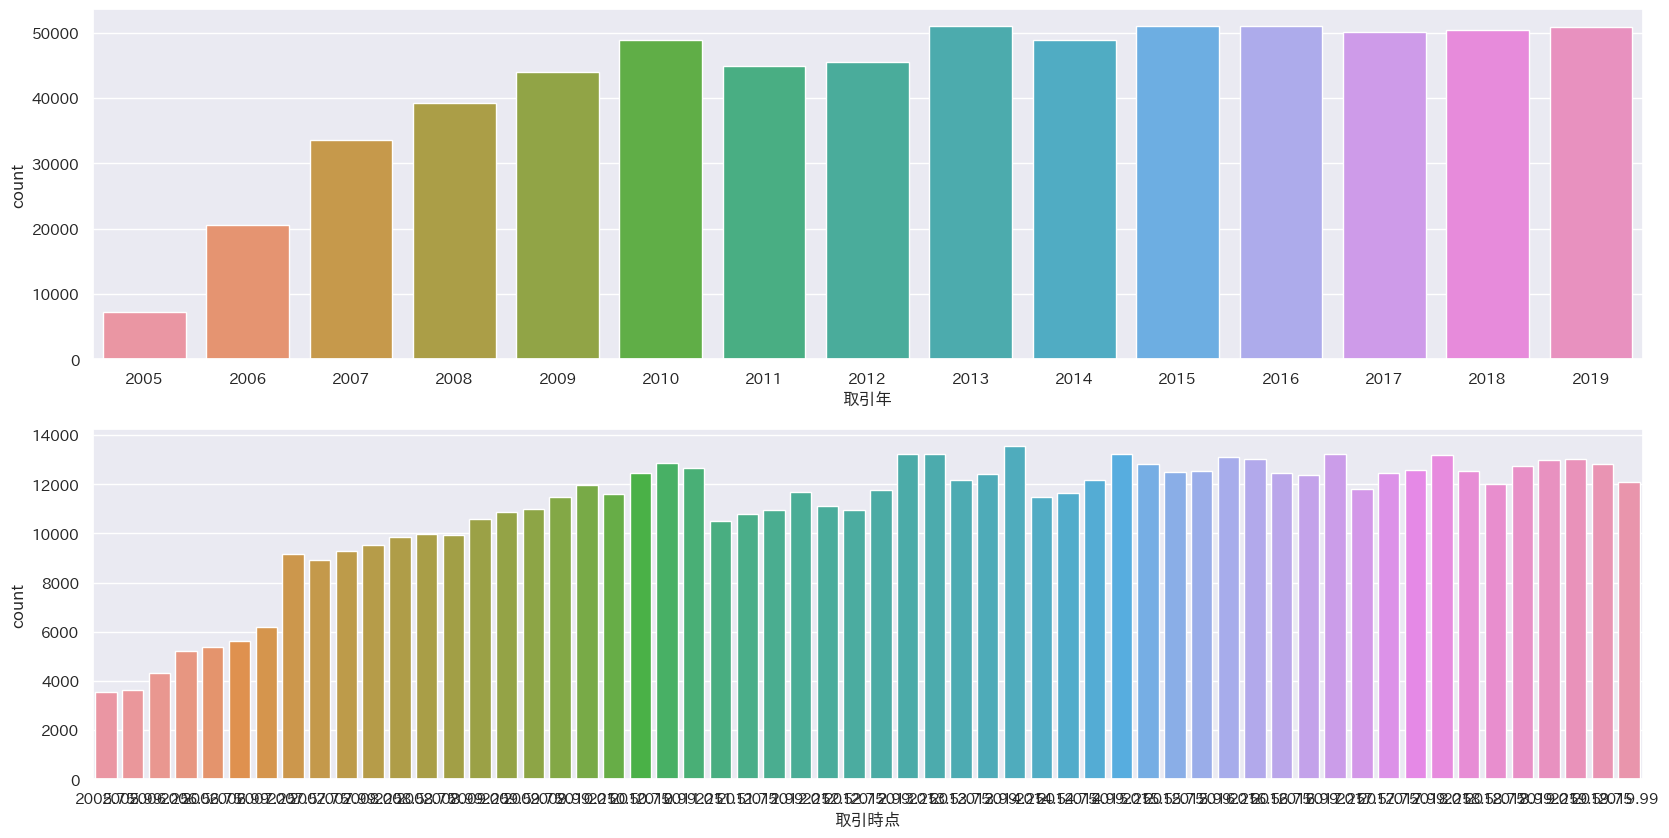

In [72]:
fig, axes = plt.subplots(2, 1, figsize=(20, 10))
sns.countplot(x="取引年", data=df.sort_values("取引年"), ax=axes[0])
sns.countplot(x="取引時点", data=df, ax=axes[1])